Подключим необходимые библиотеки

In [1]:
import numpy as np
from IPython import display
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import random
from torchtext.legacy import data
from torchtext.legacy import datasets
%matplotlib inline

Установим фиксированный `random seed` для повторяемости эксперимента

In [2]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Загрузим данные. Разобъём на `train`, `valid`, `test`

In [3]:
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

In [4]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [5]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [6]:
def cut_words(ddata, max_length=20):
    for i in range(len(ddata.examples)):
        ddata.examples[i].text = ddata.examples[i].text[:max_length]

In [7]:
cut_words(train_data)
cut_words(valid_data)
cut_words(test_data)

Построим словарь по предподсчитанным векторам

In [8]:
MAX_VOCAB_SIZE = 10_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [9]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

Опишем модель $-$ базовая `RNN`

In [10]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        self.embedded = self.embedding(text)
        if model.training:
            self.embedded.retain_grad()
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(self.embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

    def embedding_grad(self):
        if model.training:
            return self.embedded.grad
        else:
            return None

In [11]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM)

In [12]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
criterion = nn.BCEWithLogitsLoss()

In [14]:
model = model.to(device)
criterion = criterion.to(device)

In [15]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [16]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Обучим модель на тренировочной выборке

In [144]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'imdb20.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.695 | Train Acc: 52.46%
	 Val. Loss: 0.681 |  Val. Acc: 56.72%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.657 | Train Acc: 61.22%
	 Val. Loss: 0.671 |  Val. Acc: 60.27%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.605 | Train Acc: 68.00%
	 Val. Loss: 0.676 |  Val. Acc: 60.20%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.549 | Train Acc: 73.09%
	 Val. Loss: 0.644 |  Val. Acc: 66.77%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.493 | Train Acc: 77.00%
	 Val. Loss: 0.667 |  Val. Acc: 64.53%


In [64]:
model.load_state_dict(torch.load('imdb20.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.654 | Test Acc: 65.55%


In [65]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_proba(texts):
    model.eval()
    
    tokenized = [[tok.text for tok in nlp.tokenizer(text)] for text in texts]
    padded = TEXT.pad(tokenized)
    indexed = [[TEXT.vocab.stoi[tok] for tok in text] for text in padded]
    
    i = 0
    predictions = []
    while i < len(texts):
        j = min(i + BATCH_SIZE, len(texts))
        input_tensor = torch.LongTensor(indexed[i:j]).to(device).T
        output = torch.sigmoid(model(input_tensor))
        predictions += output.cpu().detach().tolist()
        i = j
    
    predictions = np.array(predictions)
    stacked_preds = np.stack([1 - predictions, predictions]).T[0]
    return stacked_preds

Теперь получим интерпретируемую модель методом **LIME**

In [66]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['neg', 'pos'])

In [90]:
np.random.seed(42)

sample_size = 1000
sample_idx = np.random.randint(0, len(test_data), sample_size)
sample_texts = [" ".join(test_data[idx].text) for idx in sample_idx]

In [102]:
true_preds = np.array([predict_proba([text])[0, 1] for text in sample_texts])

In [48]:
lime_probas = []
for text in tqdm(sample_texts):
    exp = explainer.explain_instance(text, predict_proba, num_features=6)
    lime_probas.append(exp.predict_proba)
lime_preds = np.stack(lime_probas)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:48<00:00,  1.89it/s]


In [22]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

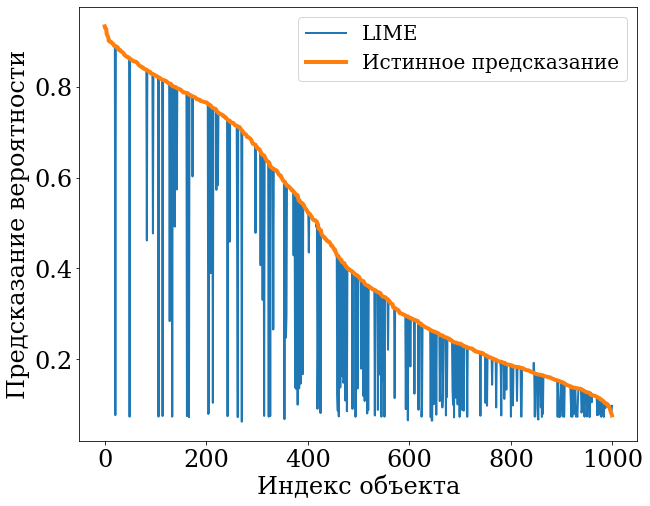

In [108]:
item_idxs = true_preds.argsort()[::-1]

fig = plt.figure(figsize=(10, 8))
plt.plot(lime_preds[item_idxs, 1], label='LIME')
plt.plot(true_preds[item_idxs], label='Истинное предсказание', lw=4)

plt.xlabel('Индекс объекта')
plt.ylabel('Предсказание вероятности')
plt.legend(loc=0)
fig.axes[0].set_rasterized(True)
plt.savefig('../figures/lime_proba_est.eps', format='eps')
plt.show()

In [131]:
lime_rmse = np.sqrt(np.mean(np.abs(true_preds - lime_preds[:, 1])**2))
lime_rmse.round(5)

0.11822

In [300]:
from numpy import dot
from numpy.linalg import norm

cos_sims = []
for i in range(sample_size):
    a = true_preds[i]
    b = lime_preds[i]
    cos_sims.append(dot(a, b) / (norm(a) * norm(b)))

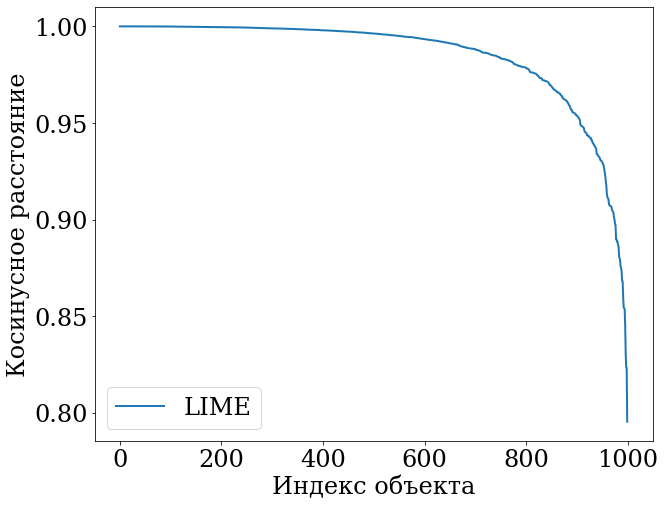

In [333]:
fig = plt.figure(figsize=(10, 8))
plt.plot(np.sort(cos_sims)[::-1], label='LIME')
plt.xlabel('Индекс объекта')
plt.ylabel('Косинусное расстояние')
plt.legend(loc=3)
fig.axes[0].set_rasterized(True)
plt.savefig('../figures/lime_cosine.eps', format='eps')
plt.show()

Получим интерпретацию методом **OpenBox**

In [23]:
from copy import copy

np.random.seed(42)

sample_size = 1000
sample_idx = np.random.randint(0, len(test_data), sample_size)
sample_texts = [test_data[idx].text for idx in sample_idx]
sample_sent = [" ".join(text) for text in sample_texts]
sample_indexed = [[TEXT.vocab.stoi[tok] 
                   for tok in text] for text in sample_texts]

sample_sent_sim = []
sample_indexed_sim = []
for i in range(sample_size):
    indexed = sample_indexed[i]
    text_len = len(indexed)
    word_idx = np.random.randint(text_len)
    
    indexed_sim = copy(indexed)
    indexed_sim[word_idx] = 0  # unknown word
    sample_indexed_sim.append(indexed_sim)
    
    text_sim = copy(sample_texts[i])
    text_sim[word_idx] = 'unknownwordhelper'
    sample_sent_sim.append(" ".join(text_sim))

In [24]:
def predict_proba_by_indexed(indexed):
    model.train()
    input_tensor = torch.LongTensor([indexed]).to(device).T
    output = torch.sigmoid(model(input_tensor))
    output.backward()
    prediction = output
    return prediction, model.embedded, model.embedding_grad()

In [25]:
true_proba = []
openbox_proba_ests = []

for idx in tqdm(range(sample_size)):
    res = predict_proba_by_indexed(sample_indexed[idx])
    proba = res[0]
    embed = res[1]
    grads = res[2]

    sim_res = predict_proba_by_indexed(sample_indexed_sim[idx])
    sim_proba = sim_res[0]
    sim_embed = sim_res[1]
    sim_grads = sim_res[2]

    true_proba.append(proba.item())
    
    openbox_proba_est = proba + torch.sum(grads * (sim_embed - embed))
    openbox_proba_ests.append(openbox_proba_est.item())

true_proba = np.array(true_proba)
openbox_proba_ests = np.array(openbox_proba_ests)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.14it/s]


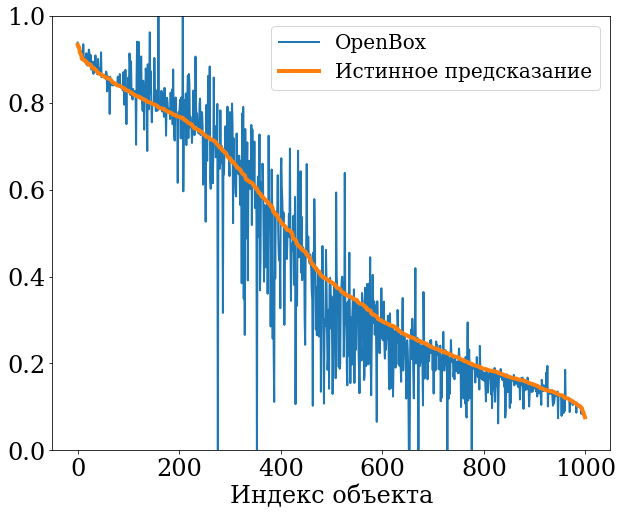

In [148]:
item_idxs = true_proba.argsort()[::-1]

fig = plt.figure(figsize=(10, 8))
plt.xlabel('Индекс объекта')

plt.plot(openbox_proba_ests[item_idxs], label='OpenBox')
plt.plot(true_proba[item_idxs], label='Истинное предсказание', lw=4)
plt.ylim([0, 1])
plt.legend()
fig.axes[0].set_rasterized(True)
plt.savefig('../figures/openbox_proba_est.eps', format='eps')
plt.show()

In [149]:
openbox_rmse = np.sqrt(np.mean((true_proba - openbox_proba_ests)**2))
openbox_rmse.round(5)

0.08292

In [139]:
from numpy import dot
from numpy.linalg import norm

cos_sims_openbox = []
for i in range(sample_size):
    a = np.array([1 - true_proba[i], true_proba[i]])
    b = np.array([1 - openbox_proba_ests[i], openbox_proba_ests[i]])
    
    cos_sims_openbox.append(dot(a, b) / (norm(a) * norm(b)))

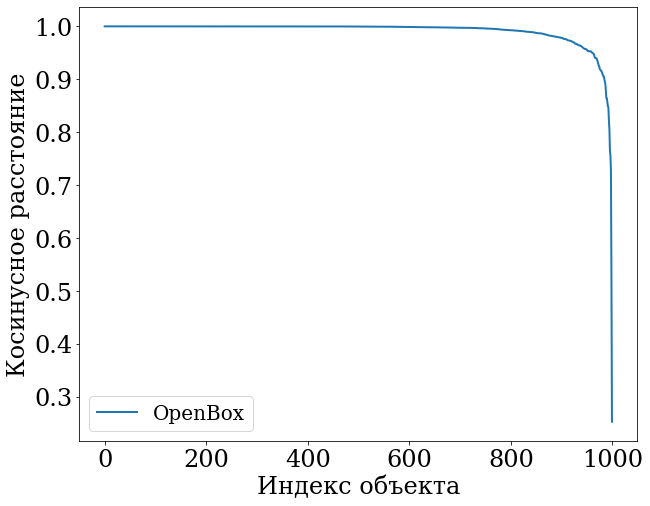

In [141]:
fig = plt.figure(figsize=(10, 8))
plt.plot(np.sort(cos_sims_openbox)[::-1], label='OpenBox')
plt.xlabel('Индекс объекта')
plt.ylabel('Косинусное расстояние')
plt.legend(loc=3)
fig.axes[0].set_rasterized(True)
plt.savefig('../figures/openbox_cosine.eps', format='eps')
plt.show()